In [7]:
import zipline
from zipline.api import order_target_percent, symbol,  \
    set_commission, set_slippage, schedule_function, \
    date_rules, time_rules, attach_pipeline, pipeline_output, \
     get_open_orders
from pandas import Timestamp
import matplotlib.pyplot as plt
import pyfolio as pf
import pandas as pd
import numpy as np  
from scipy import stats  
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
from zipline_norgatedata.pipelines import NorgateDataIndexConstituent
from zipline.pipeline import Pipeline
from numba import jit, prange
import timeit
from timeit import default_timer as timer
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
import os
from zipline.data.bundles import load
from random import sample
import time

def momentum_score(ts):
    """
    Input:  Price time series.
    Output: Annualized exponential regression slope, 
            multiplied by the R2
    """
    # Make a list of consecutive numbers
    x = np.arange(len(ts)) 
    # Get logs
    log_ts = np.log(ts) 
    # Calculate regression values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)
    #slope, intercept, r_value, std_err = linregressNumba(x, log_t.values)
    
    # annualize slope (%)
    annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100
    # adjust for fitness
    score = annualized_slope * (r_value ** 2)
    return score

def momentum_rsquare(ts):
    """
    Input:  Price time series.
    Output: Annualized exponential regression slope, 
            multiplied by the R2
    """
    # Make a list of consecutive numbers
    x = np.arange(len(ts)) 
    # Get logs
    log_ts = np.log(ts) 
    # Calculate regression values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)

    return (r_value ** 2)

def momentum_slope(ts):
    """
    Input:  Price time series.
    Output: Annualized exponential regression slope, 
            multiplied by the R2
    """
    # Make a list of consecutive numbers
    x = np.arange(len(ts)) 
    # Get logs
    log_ts = np.log(ts) 
    # Calculate regression values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)
    # annualize slope (%)
    annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100
    
    return annualized_slope

# convert covariance matrix to correlation matrix
def cov2corr(cov, return_vol=False):
    '''convert covariance matrix to correlation matrix

    Parameters
    ----------
    cov : array_like, 2d
        covariance matrix, see Notes

    Returns
    -------
    corr : ndarray (subclass)
        correlation matrix
    return_vol : bool
        If this is true then the standard deviation is also returned.
        By default only the correlation matrix is returned.

    Notes
    -----
    This function does not convert subclasses of ndarrays. This requires
    that division is defined elementwise. np.ma.array and np.matrix are allowed.

    '''
    cov = np.asanyarray(cov)
    vol_ = np.sqrt(np.diag(cov))
    corr = cov / np.outer(vol_, vol_)
    if return_vol:
        return corr, vol_
    else:
        return corr

# convert correlation matrix to covariance matrix given standard deviation
def corr2cov(corr, vol):
    '''convert correlation matrix to covariance matrix given standard deviation

    Parameters
    ----------
    corr : array_like, 2d
        correlation matrix, see Notes
    vol : array_like, 1d
        standard deviation

    Returns
    -------
    cov : ndarray (subclass)
        covariance matrix

    Notes
    -----
    This function does not convert subclasses of ndarrays. This requires
    that multiplication is defined elementwise. np.ma.array are allowed, but
    not matrices.

    '''
    corr = np.asanyarray(corr)
    vol_ = np.asanyarray(vol)
    cov = corr * np.outer(vol_, vol_)
    return cov

# find nearest positive-definite matrix to input
def nearestPD(A):
    '''Find nearest positive-definite matrix to input

    N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    '''

    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    H = np.dot(V.T, np.dot(np.diag(s), V))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    # if positive-definite return
    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    
    k = 1
    # while not positive-definite, apply adjustment
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

# determine if matrix is positive-definite
def isPD(B):
    '''Returns true when input is positive-definite, via Cholesky'''
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False

# compute risk parity weights
def computeWeightsRP(covariances):
    # extract instrument IDs
    instrumentIds=covariances.index
    # compute weights
    a = (1 / np.sqrt(np.diag(covariances))) 
    weights=a / sum(a)
    # create weights dataframe
    weightsRP=pd.DataFrame(data=weights,index=instrumentIds,columns=['weights']) 
    
    return weightsRP

# determine order implied by the hierarchical tree
def seriation(Z, N, cur_index):
    '''Return order implied by a hierarchical tree (dendrogram).
    
       :param Z: A hierarchical tree (dendrogram).
       :param N: The number of points given to the clustering process.
       :param cur_index: The position in the tree for the recursive traversal.
       
       :return: The order implied by the hierarchical tree Z.
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index - N, 0])
        right = int(Z[cur_index - N, 1])
        return (seriation(Z, N, left) + seriation(Z, N, right))

#  transform a distance matrix intoa sorted distance matrix according to order 
# implied by the hierarchical tree  
def computeSerialMatrix(dist_mat, method="ward"):
    '''Return a sorted distance matrix.
    
       :param dist_mat: A distance matrix.
       :param method: A string in ["ward", "single", "average", "complete"].
        
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    # convert square-form distance matrix to vector-form distance vector
    flat_dist_mat = squareform(dist_mat)
    # perform hierarchical/agglomerative clustering
    res_linkage = linkage(flat_dist_mat, method=method)
    # determine order implied by a hierarchical tree
    res_order = seriation(res_linkage, N, N + N - 2)
    # create output array structure for distance matrix
    seriated_dist = np.zeros((N, N))
    # create ordered square-form distance matrix
    a,b = np.triu_indices(N, k=1)
    seriated_dist[a,b] = dist_mat[[res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

def computeWeightsHRP(cov,method='single'):
    # extract instrument IDs
    instrumentIds=cov.index
    # create covariances dataframe with index 1 to N
    covariances=pd.DataFrame(data=cov.values)
    # convert covariances to correlation
    C,vols=cov2corr(covariances, return_vol=True)
    # convert correlations to distances
    distances=convertCorrelation2Distance(C)
    # sort distance matrix according to the order implied by the hierarchical tree (dendrogram)
    orderedDistanceMatrix, orderedIndex, orderedlinkage = computeSerialMatrix(distances, 
        method=method)
    # create weight dataframe 
    weights = pd.Series(1, index=orderedIndex)
    # create clustered instrument index list
    clusteredInstruments = [orderedIndex]

    # iterate over each instrument
    while len(clusteredInstruments) > 0:
        # separate cluster nodes into those with degree 1 and those with degree greater than 1
        clusteredInstruments=separateClusterNodes(clusteredInstruments)
        # iterate over sub-clusters
        for subcluster in range(0, len(clusteredInstruments), 2):
            # extract left cluster
            left_cluster = clusteredInstruments[subcluster]
            # extract right cluster
            right_cluster = clusteredInstruments[subcluster + 1]
        
            # extract covariances for left cluster
            left_subcovar = covariances[left_cluster].loc[left_cluster]
            # compute inverse of vol 
            inv_diag = 1 / np.diag(left_subcovar.values)
            # compute weight
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            # compute left cluster variance
            left_cluster_var = np.dot(parity_w, np.dot(left_subcovar, parity_w))

            # extract covariances for right cluster
            right_subcovar = covariances[right_cluster].loc[right_cluster]
            # compute inverse of vol
            inv_diag = 1 / np.diag(right_subcovar.values)
            # compute weight
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            # compute right cluster variance
            right_cluster_var = np.dot(parity_w, np.dot(right_subcovar, parity_w))

            # compute left allocation factor
            allocation_factor = 1 - left_cluster_var / (left_cluster_var + right_cluster_var)

            # apply left allocation factor
            weights[left_cluster] *= allocation_factor
            # apply right allocation factor
            weights[right_cluster] *= 1 - allocation_factor

    # create weights dataframe
    weightsHRP=pd.DataFrame(data=weights.values,index=instrumentIds[weights.index],
        columns=['weights']) 
    
    return weightsHRP,orderedIndex,orderedlinkage

# convert correlation matrix to distance matrix
def convertCorrelation2Distance(C):
    # address precision errors
    np.fill_diagonal(C, 1)
    # compute distances
    distances = np.sqrt((1 - C) / 2)
    # address precision errors
    np.fill_diagonal(distances, 0)    
    
    return distances

# separate cluster nodes into those with degree 1 and those with degree greater than 1
def separateClusterNodes(clusteredInstruments):
    # separate cluster nodes into those with degree 1 and those with degree greater than 1
    clusteredInstruments = [cluster[start:end] for cluster in clusteredInstruments for start, 
                            end in ((0, len(cluster) // 2),(len(cluster) // 2, len(cluster))) if len(cluster) > 1]
    return clusteredInstruments


"""
Initialization and trading logic
"""

def make_pipeline():
   indexconstituent = NorgateDataIndexConstituent(bundleDict[parameters['targetUniverse']]['universeTicker'])
   return Pipeline(
       columns={
            'NorgateDataIndexConstituent':indexconstituent},
       screen = indexconstituent)


def initializeMomentum(context):
    # extract parameters
    intial_portfolio=parameters['intial_portfolio']
    enable_commission=parameters['enable_commission']
    commission_pct=parameters['commission_pct']
    enable_slippage=parameters['enable_slippage']
    slippage_volume_limit=parameters['slippage_volume_limit']
    slippage_impact=parameters['slippage_impact']    
    
   # build pipeline
    attach_pipeline(make_pipeline(), 'norgatedata_pipeline', chunks=9999,eager=True)
    
    # Set commission and slippage.
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
    set_commission(comm_model)

    if enable_slippage:
        slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit,
            price_impact=slippage_impact)
        set_slippage(slippage_model)
    else:
        slippage_model=FixedSlippage(spread=0.0)        
    
    # used only for progress output
    context.last_month = intial_portfolio
        
    # schedule rebalance monthly.
    schedule_function(func=rebalanceMomentum,
        date_rule=date_rules.month_start(),
        #date_rule=date_rules.week_end(days_offset=4),
        time_rule=time_rules.market_open()
        #time_rule=time_rules.market_close()
    )

def initializeFull(context):
    # extract parameters
    intial_portfolio=parameters['intial_portfolio']
    enable_commission=parameters['enable_commission']
    commission_pct=parameters['commission_pct']
    enable_slippage=parameters['enable_slippage']
    slippage_volume_limit=parameters['slippage_volume_limit']
    slippage_impact=parameters['slippage_impact']    
    
    # build pipeline
    attach_pipeline(make_pipeline(), 'norgatedata_pipeline', chunks=9999,eager=True)
    
    # Set commission and slippage.
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
    set_commission(comm_model)

    if enable_slippage:
        slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit,
            price_impact=slippage_impact)
        set_slippage(slippage_model)
    else:
        slippage_model=FixedSlippage(spread=0.0)        
    
    # used only for progress output
    context.last_month = intial_portfolio
        
    # schedule rebalance monthly.
    schedule_function(func=rebalanceFull,
        date_rule=date_rules.month_start(),
        #date_rule=date_rules.week_end(days_offset=4),
        time_rule=time_rules.market_open()
        #time_rule=time_rules.market_close()
    )

def rebalanceMomentum(context, data):
    # extract parameters
    momentum_window=parameters['momentum_window']
    minimum_momentum=parameters['minimum_momentum']
    portfolio_size=parameters['portfolio_size']
    cash_reserve_percent=parameters['cash_reserve_percent']
    enable_trend_filter=parameters['enable_trend_filter']
    trend_filter_window=parameters['trend_filter_window']
    clusteringMethod=parameters['clusteringMethod']
    hrpFlag=parameters['hrpFlag']
    writeFlag=parameters['writeFlag']
    backtestFlag=parameters['backtestFlag']
    
    # Write some progress output during the backtest
    #output_progress(context)
    context.pipeline_data = pipeline_output('norgatedata_pipeline')
    # fetch current date
    current_date = zipline.api.get_datetime().date()

    # fetch universe (nInstruments)
    current_universe = context.pipeline_data.index
    
    if backtestFlag==False:
        # find instruments in subset
        subsetUniverseIndex=current_universe.isin(universeSubset)
        # apply subset
        current_universe=current_universe[subsetUniverseIndex]
        #print(str(current_date)+"|"+str(len(current_universe)))
    
    #print(current_universe)
    # fetch historical data window (momentumWindow x nInstruments)
    data_window = data.history(current_universe, "close", momentum_window, "1d")
    #print(data_window)
    # drop assets without a full sample
    full_data_window = data_window.dropna(axis=1,how='any')    
    
    # perform momentum ranking
    #momentum_ranking = full_data_window.apply(momentum_score).sort_values(ascending=False)
    momentum_ranking = full_data_window.apply(momentum_score)
    momentum_state=momentum_ranking.copy().to_frame()
    momentum_ranking=momentum_ranking.sort_values(ascending=False)
    # store momentum state
    momentum_state['slope'] = full_data_window.apply(momentum_slope)
    momentum_state['rsquare'] = full_data_window.apply(momentum_rsquare)
    momentum_state['as_of_date']=current_date
    momentum_state.columns=['score','slope','rsquare','as_of_date']        
        
        
    # PROCESS EXITS
    
    # create open position list
    open_positions = list(context.portfolio.positions.keys())
    # iterate over open positions
    for instrument in context.portfolio.positions:
        # close position if no longer in index universe
        if (instrument not in current_universe):
            # place order to close position
            order_target_percent(instrument, 0.0)
            # remove position from open position list
            open_positions.remove(instrument)          
        # close position if momentum falls below threshold
        elif momentum_ranking[instrument] < minimum_momentum:
            # place order to close position
            order_target_percent(instrument, 0.0)
            # remove position from open position list
            open_positions.remove(instrument)         
    
    # UPDATE TREND FILTER STATE
    
    # determine trend filter state
    if enable_trend_filter:
        # fetch historical total return index data for universe
        index_data_window = data.history(symbol(bundleDict[parameters['targetUniverse']]['trend_filter_symbol']),
            'close', trend_filter_window, '1d')
        # determine trend filter state
        trend_filter_state = index_data_window.iloc[-1] > index_data_window.mean()
    else:
        trend_filter_state = True
    #
    if writeFlag:
        # add trend filter state
        momentum_state['trend_filter_state']=trend_filter_state
        # write momentum state
        momentum_state.to_csv(outputDirectory+strategyName+'_momentumState_'+str(current_date)+".csv")

    else:
        pass

    # if trend filter state is false, skip adding new positions via stock selection        
    if trend_filter_state == False:               
        return  
    
    # STOCK SELECTION
        
    # determine number of positions to add to get to target number of positions
    n_new_positions = portfolio_size - len(open_positions)
    # find new positions
    add_list = momentum_ranking.loc[~momentum_ranking.index.isin(open_positions)][:n_new_positions]
    # create new portfolio dataframe object
    new_portfolio = pd.concat((add_list, momentum_ranking.loc[momentum_ranking.index.isin(open_positions)]))

    # POSITION SIZING
    # compute covariance for portfolio holdings
    covariance=full_data_window[new_portfolio.index].pct_change().cov(min_periods=(momentum_window-1))
    #print(covariance.shape)
    
    if hrpFlag:
        # compute HRP weights
        weightsRP,orderedIndex,orderedlinkage=computeWeightsHRP(covariance,method=clusteringMethod)
    else:
        # compute RP weights
        weightsRP=computeWeightsRP(covariance)

    # determine cash percent
    current_cash_percent = context.portfolio.cash / context.portfolio.portfolio_value
    
    weight_adjustment=-cash_reserve_percent/float(len(weightsRP))
    
    # adjust weights for cash
    weightsRP['weights_adjusted']=weightsRP['weights'] + weight_adjustment        
        
    if writeFlag:
                
        if hrpFlag:
            # compute correlation
            correlation=pd.DataFrame(data=cov2corr(covariance, return_vol=False),
                index=covariance.index,columns=covariance.index)            
            # write weights
            weightsRP.to_csv(outputDirectory+strategyName+'_weightsHRP_'+str(current_date)+".csv")
            # write covariance, correlation, and weight results
            covariance.to_csv(outputDirectory+strategyName+'_covariance_'+str(current_date)+".csv")
            correlation.to_csv(outputDirectory+strategyName+'_correlation_'+str(current_date)+".csv")            
        else:
            # write weights
            weightsRP.to_csv(outputDirectory+strategyName+'_weightsRP_'+str(current_date)+".csv")
    else:
        # write weights
        #weightsRP.to_csv(outputDirectory+strategyName+'_weightsRP_'+str(current_date)+".csv") 
        pass
    
    # determine cash percent
    current_cash_percent = context.portfolio.cash / context.portfolio.portfolio_value
    
    # iterate over new portfolio
    for instrument, momentum in new_portfolio.iteritems():
        # extract target weight (adjusted for cash reserve)
        weight = np.max([weightsRP['weights'].loc[instrument] + weight_adjustment,0])
        
        # rebalance open position
        if instrument in open_positions:
            # place order to rebalance position
            order_target_percent(instrument, weight)
        
        # add new positions
        else:
            if momentum_ranking[instrument] > minimum_momentum :
                # place order to add position
                order_target_percent(instrument, weight)
                



def rebalanceFull(context, data):
    # extract parameters
    momentum_window=parameters['momentum_window']
    cash_reserve_percent=parameters['cash_reserve_percent']
    enable_trend_filter=parameters['enable_trend_filter']
    trend_filter_window=parameters['trend_filter_window']
    clusteringMethod=parameters['clusteringMethod']
    hrpFlag=parameters['hrpFlag']
    writeFlag=parameters['writeFlag']
    
    # Write some progress output during the backtest
    #output_progress(context)
    context.pipeline_data = pipeline_output('norgatedata_pipeline')
    # fetch current date
    current_date = zipline.api.get_datetime().date()
    # fetch universe (nInstruments)
    current_universe = context.pipeline_data.index
    
    if backtestFlag==False:
        # find instruments in subset
        subsetUniverseIndex=current_universe.isin(universeSubset)
        # apply subset
        current_universe=current_universe[subsetUniverseIndex]
        #print(str(current_date)+"|"+str(len(current_universe)))
    
    # fetch historical data window (momentumWindow x nInstruments)
    data_window = data.history(current_universe, "close", momentum_window, "1d")
    
    # drop assets without a full sample
    full_data_window = data_window.dropna(axis=1,how='any')
    
    # UPDATE TREND FILTER STATE
    # determine trend filter state
    if enable_trend_filter:
        # fetch historical total return index data for universe
        index_data_window = data.history(symbol(bundleDict[parameters['targetUniverse']]['trend_filter_symbol']),
            'close',trend_filter_window,'1d')
        # determine trend filter state
        trend_filter_state = index_data_window.iloc[-1] > index_data_window.mean()
        # if trend filter state is false, skip adding new positions
    else:
        trend_filter_state = True
    
    # PROCESS EXITS
    
    # create open position list
    open_positions = list(context.portfolio.positions.keys())
    # iterate over open positions
    for instrument in context.portfolio.positions:
        # close position if no longer in index universe
        if (instrument not in current_universe) or (trend_filter_state == False):
            # place order to close position
            order_target_percent(instrument, 0.0)
            # remove position from open position list
            open_positions.remove(instrument)
    
    # move to next date
    if trend_filter_state == False:
        return    
    
    # POSITION SIZING
    # compute covariance
    covariance=full_data_window.pct_change().cov(min_periods=(momentum_window-1))
    
    if hrpFlag:
        # compute HRP weights
        weightsRP,orderedIndex,orderedlinkage=computeWeightsHRP_v2(covariance,
            method=clusteringMethod)
    else:
        # compute RP weights
        weightsRP=computeWeightsRP(covariance)

    # determine cash percent
    current_cash_percent = context.portfolio.cash / context.portfolio.portfolio_value
    
    weight_adjustment=-cash_reserve_percent/float(len(weightsRP))
    
    # adjust weights for cash
    weightsRP['weights_adjusted']=weightsRP['weights'] + weight_adjustment        
        
    if writeFlag:
                
        if hrpFlag:
            # compute correlation
            correlation=pd.DataFrame(data=cov2corr(covariance, return_vol=False),
                index=covariance.index,columns=covariance.index)            
            # write weights
            weightsRP.to_csv(outputDirectory+strategyName+'_weightsHRP_'+str(current_date)+".csv")
            # write covariance, correlation, and weight results
            covariance.to_csv(outputDirectory+strategyName+'_covariance_'+str(current_date)+".csv")
            correlation.to_csv(outputDirectory+strategyName+'_correlation_'+str(current_date)+".csv")            
        else:
            # write weights
            weightsRP.to_csv(outputDirectory+strategyName+'_weightsRP_'+str(current_date)+".csv")
         
    # iterate over new portfolio
    for instrument, weight in weightsRP.iterrows():
        # extract target weight (adjusted for cash reserve)
        weight =  np.max([weight['weights_adjusted'],0])
        # place order to rebalance position
        order_target_percent(instrument, weight)

def analyze(context, perf):
    
    perf['max'] = perf.portfolio_value.cummax()
    perf['dd'] = (perf.portfolio_value / perf['max']) - 1
    maxdd = perf['dd'].min()
    sharpe = perf.sharpe.iloc[-1]
    ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1
    
    print("Annualized Return: {:.2%} Max Drawdown: {:.2%} Sharpe: {:.4}".format(ann_ret, maxdd, sharpe))
    
    # add functions to export results for R markdown reporting

    return  

def annualReturn(perf):
    return (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / perf.trading_days[-1]))) - 1

def tail_ratio(returns):
    """Determines the ratio between the right (95%) and left tail (5%).
    For example, a ratio of 0.25 means that losses are four times
    as bad as profits.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    Returns
    -------
    float
        tail ratio
    """

    return np.abs(np.percentile(returns, 95)) / np.abs(np.percentile(returns, 5))

def extractSymbol(ziplineTicker):
    return ziplineTicker.split('[')[1].split(']')[0]

def writePositions(outputDirectory,strategyName,perf):
    # define output file name
    outputFileName=strategyName+'_positions.csv'
    # open output file handle
    outputFileHandle=open(outputDirectory+outputFileName,'w')
    # set header flag
    headerFlag=True
    # iterate over position object
    for dateTime,positions in perf.positions.items():
        # if we have positions for datetime
        if len(positions)>0:
            df=pd.DataFrame(positions)
            df['datetime']=dateTime
            df['symbol']=df['sid'].apply(lambda x : extractSymbol(str(x)))
            df['strategyName']=strategyName
            
            if headerFlag:
                df.to_csv(outputFileHandle,header=True,index=False,
                    columns=['sid','symbol','datetime','amount','cost_basis',
                    'last_sale_price'])
                # set header flag
                headerFlag=False
            else:
                df.to_csv(outputFileHandle,header=False,index=False,
                    columns=['sid','symbol','datetime','amount','cost_basis',
                    'last_sale_price'])
    # close output file handle
    outputFileHandle.close()
    return outputFileName

def writeTransactions(outputDirectory,strategyName,perf):
    # define output file name
    outputFileName=strategyName+'_transactions.csv'    
    # open output file handle
    outputFileHandle=open(outputDirectory+outputFileName,'w')
    # set header flag
    headerFlag=True
    # iterate over transactions object
    for dateTime,transactions in perf.transactions.items():
        # if we have transactions for datetime
        if len(transactions)>0:
            df=pd.DataFrame(transactions)
            df['datetime']=dateTime
            df['symbol']=df['sid'].apply(lambda x : extractSymbol(str(x)))
            df['strategyName']=strategyName
            
            if headerFlag:
                df.to_csv(outputFileHandle,header=True,index=False,
                    columns=['sid','symbol','datetime','order_id','amount',
                    'price','commission','dt'])
                # set header flag
                headerFlag=False
            else:
                df.to_csv(outputFileHandle,header=False,index=False,
                    columns=['sid','symbol','datetime','order_id','amount',
                    'price','commission','dt'])
    # close output file handle
    outputFileHandle.close()
    return outputFileName

def writeOrders(outputDirectory,strategyName,perf):
    # define output file name
    outputFileName=strategyName+'_orders.csv'
    # open output file handle
    outputFileHandle=open(outputDirectory+outputFileName,'w')
    # set header flag
    headerFlag=True
    # iterate over orders object
    for dateTime,orders in perf.orders.items():
        # if we have transactions for datetime
        if len(orders)>0:
            df=pd.DataFrame(orders)
            df['datetime']=dateTime
            df['symbol']=df['sid'].apply(lambda x : extractSymbol(str(x)))
            df['strategyName']=strategyName
            
            if headerFlag:
                df.to_csv(outputFileHandle,header=True,index=False,
                    columns=['sid','symbol','datetime','id','amount','commission',
                    'created','dt','filled','limit','limit_reached','reason',
                    'status','stop','stop_reached'])
                # set header flag
                headerFlag=False
            else:
                df.to_csv(outputFileHandle,header=False,index=False,
                    columns=['sid','symbol','datetime','id','amount','commission',
                    'created','dt','filled','limit','limit_reached','reason',
                    'status','stop','stop_reached'])
    # close output file handle
    outputFileHandle.close()
    return outputFileName

def writeStrategyOutput(outputDirectory,strategyName,perf):
    performance=pd.concat([perf.period_open,perf.period_close,perf.trading_days,
        perf.capital_used,perf.starting_cash,perf.starting_exposure,perf.starting_value,
        perf.ending_cash,perf.ending_exposure,perf.ending_value,perf.long_exposure,
        perf.long_value,perf.longs_count,perf.short_exposure,perf.short_value,
        perf.shorts_count,perf.pnl,perf.portfolio_value,perf.returns,perf.gross_leverage,
        perf.net_leverage,perf.max_leverage,perf.dd,perf.max_drawdown,perf.sharpe,
        perf.sortino,perf.alpha,perf.beta,perf.excess_return,perf.algo_volatility,
        perf.algorithm_period_return,perf.benchmark_volatility,perf.benchmark_period_return],
        axis=1)
    
    # add strategy name
    performance['strategyName']=strategyName    
    # define output file name
    performanceFileName=strategyName+'_performance.csv'
    # write performance
    performance.to_csv(outputDirectory+performanceFileName)
    # write positions
    positionsFileName=writePositions(outputDirectory,strategyName,perf)
    # write positions
    transactionsFileName=writeTransactions(outputDirectory,strategyName,perf)
    # write positions
    ordersFileName=writeOrders(outputDirectory,strategyName,perf)    
    
    return performance,performanceFileName,positionsFileName,transactionsFileName,ordersFileName

def fetchUniverse(bundle):
    # define bundle
    bundle = load(bundle, os.environ)
    # pull symbols
    symbols = bundle.asset_finder.retrieve_all(bundle.asset_finder.equities_sids)

    return symbols
    
def sampleUniverse(bundle,nInstrumentSample):
    # fetch universe
    symbols = fetchUniverse(bundle)
    # take random subset
    symbols = np.random.choice(symbols,nInstrumentSample)
    
    return symbols

def buildStrategyName(targetUniverse,hrpFlag,enable_trend_filter,scenarioIndex):
    
    if hrpFlag:
        if enable_trend_filter:
            strategyName='HRP-S-TF-M_rm_'+targetUniverse+"_"+str(scenarioIndex)
        else:
            strategyName='HRP-S-nTF-M_rm_'+targetUniverse+"_"+str(scenarioIndex)
    else:
        if enable_trend_filter:
            strategyName='RP-S-TF-M_rm_'+targetUniverse+"_"+str(scenarioIndex)
        else:
            strategyName='RP-S-nTF-M_rm_'+targetUniverse+"_"+str(scenarioIndex)      
    
    return strategyName

def buildStrategyTestName(targetUniverse,enable_trend_filter):
    
    if enable_trend_filter:
        strategyTestName='HRPvsRP-S-TF-M_rm_'+targetUniverse+'_parameter_search_results.csv'
    else:
        strategyTestName='HRPvsRP-S-nTF-M_rm_'+targetUniverse+'_parameter_search_results.csv'
 
    return strategyTestName


In [8]:
# Universe Setting
bundleDict = {
    'SP500': {'universeBundleName':'norgatedata-sp500','universeTicker':'$SPX','trend_filter_symbol':'$SPXTR'},
    #'SP500': {'universeBundleName':'norgatedata-sp500','universeTicker':'$SPX','trend_filter_symbol':'$SPXTR1936'},
    'SP400': {'universeBundleName':'norgatedata-sp400','universeTicker':'$MID','trend_filter_symbol':'$MIDTR'},
    'SP600': {'universeBundleName':'norgatedata-sp600','universeTicker':'$SML','trend_filter_symbol':'$SMLTR'},
    'SP1500': {'universeBundleName':'norgatedata-sp1500','universeTicker':'$SP1500','trend_filter_symbol':'$SP1500TR'},
    'SP100': {'universeBundleName':'norgatedata-sp100','universeTicker':'$OEX','trend_filter_symbol':'$OEXTR'},
    'R1000': {'universeBundleName':'norgatedata-r1000','universeTicker':'$RUI','trend_filter_symbol':'$RUITR'},
    'R2000': {'universeBundleName':'norgatedata-r2000','universeTicker':'$RUT','trend_filter_symbol':'$RUTTR'},
    'R3000': {'universeBundleName':'norgatedata-r3000','universeTicker':'$RUA','trend_filter_symbol':'$RUATR'}
}


#outputDirectory = 'F:/Downloads/backtest/1990_2004/L168_M0_N30_RRSP/'
outputDirectory = 'F:/Downloads/backtest/2005_2020/L168_M0_N30_RRSP/'
#outputDirectory = 'F:/Downloads/backtest/1990_2019/L168_M0_N30_RRSP/'
#outputDirectory = 'F:/Downloads/backtest/1971_1989/L168_M0_N30_RRSP/'
#outputDirectory = 'F:/Downloads/backtest/1971_2004/L168_M0_N30_RRSP/'
#outputDirectory = 'F:/Downloads/backtest/1971_2019/L168_M0_N30_RRSP/'

scenarioIndex='backtest'

parameters=dict()
#parameters['start_date']=Timestamp('1971-01-01',tz='UTC')
#parameters['end_date']=Timestamp('1989-12-31',tz='UTC')

parameters['start_date']=Timestamp('2005-01-01',tz='UTC')



#parameters['end_date']=Timestamp('2019-12-31',tz='UTC')
parameters['end_date']=Timestamp('2020-02-14',tz='UTC')
#parameters['start_date']=Timestamp('1990-01-01',tz='UTC')
#parameters['end_date']=Timestamp('1989-12-31',tz='UTC')
#parameters['end_date']=Timestamp('2004-12-31',tz='UTC')
#parameters['targetUniverse']='SP1500'
parameters['targetUniverse']='SP500'
#parameters['targetUniverse']='SP400'
#parameters['targetUniverse']='SP600'
#parameters['targetUniverse']='SP100'

parameters['intial_portfolio']=100000
parameters['momentum_window']=168
parameters['minimum_momentum']=0
parameters['portfolio_size']=30
parameters['cash_reserve_percent']=0.05
parameters['enable_trend_filter']=True
#parameters['enable_trend_filter']=False
parameters['trend_filter_window']=200
parameters['clusteringMethod']='single'
parameters['hrpFlag']=True
#parameters['hrpFlag']=False
parameters['enable_commission']=True
parameters['commission_pct']=0.001
parameters['enable_slippage']=True
parameters['slippage_volume_limit']=0.1
parameters['slippage_impact']=0.05
parameters['backtestFlag']=True
parameters['writeFlag']=True

strategyName=buildStrategyName(parameters['targetUniverse'],parameters['hrpFlag'],
    parameters['enable_trend_filter'],
    'backtest_'+str(parameters['momentum_window'])+"_"+str(parameters['minimum_momentum'])+"_"+str(parameters['portfolio_size'])+"_"+str(parameters['trend_filter_window']))
#strategyTestName=buildStrategyTestName(parameters['targetUniverse'],parameters['enable_trend_filter'],
#    nInstrumentSample,nScenarios)

print(strategyName)

parameters['strategyName']=strategyName
#parameters['strategyTestName']=strategyTestName

# run strategy backtest on universe subset
perfHRP = zipline.run_algorithm(
    start=parameters['start_date'], end=parameters['end_date'], 
    initialize=initializeMomentum, 
    analyze=analyze, 
    capital_base=parameters['intial_portfolio'],
    data_frequency = 'daily', 
    bundle = bundleDict[parameters['targetUniverse']]['universeBundleName'] )

# write strategy output
performance,performanceFileName,positionsFileName,transactionsFileName,ordersFileName=writeStrategyOutput(outputDirectory,
    strategyName,perfHRP)

# extract parameter keys
keys=[str(key) for key in parameters.keys()]
# extract parameter values
values=[key for key in parameters.values()]
# create parameter data frame
parameterDf=pd.DataFrame(index=keys,data=values,columns=['parameterValue'])
# write parameters
parameterDf.to_csv(outputDirectory+strategyName+"_parameters.csv",index_label='parameterName')

#parameters['hrpFlag']=True
parameters['hrpFlag']=False

strategyName=buildStrategyName(parameters['targetUniverse'],parameters['hrpFlag'],
    parameters['enable_trend_filter'],
    'backtest_'+str(parameters['momentum_window'])+"_"+str(parameters['minimum_momentum'])+"_"+str(parameters['portfolio_size'])+"_"+str(parameters['trend_filter_window']))
#strategyTestName=buildStrategyTestName(parameters['targetUniverse'],parameters['enable_trend_filter'],
#    nInstrumentSample,nScenarios)

print(strategyName)

parameters['strategyName']=strategyName
#parameters['strategyTestName']=strategyTestName

# run strategy backtest on universe subset
perfRP = zipline.run_algorithm(
    start=parameters['start_date'], 
    end=parameters['end_date'], 
    initialize=initializeMomentum, 
    analyze=analyze, 
    capital_base=parameters['intial_portfolio'],
    data_frequency = 'daily', 
    bundle = bundleDict[parameters['targetUniverse']]['universeBundleName'] )

# write strategy output
performance,performanceFileName,positionsFileName,transactionsFileName,ordersFileName=writeStrategyOutput(outputDirectory,
    strategyName,perfRP)

# extract parameter keys
keys=[str(key) for key in parameters.keys()]
# extract parameter values
values=[key for key in parameters.values()]
# create parameter data frame
parameterDf=pd.DataFrame(index=keys,data=values,columns=['parameterValue'])
# write parameters
parameterDf.to_csv(outputDirectory+strategyName+"_parameters.csv",index_label='parameterName')

HRP-S-TF-M_rm_SP500_backtest_168_0_30_200
[2020-02-15 20:31:38.167536] INFO: Loader: Downloading benchmark data for 'SPY' from 2004-12-31 00:00:00+00:00 to 2020-02-14 00:00:00+00:00
[2020-02-15 20:31:38.266535] WARNING: Loader: Refusing to download new treasury data because a download succeeded at 2020-02-15 20:30:53.197468+00:00.
[2020-02-15 20:31:38.757892] INFO: Norgate Data: Populating NorgateDataIndexConstituent pipeline populating with $SPX on 971 securities from 2005-01-03 to 2020-02-14....
[2020-02-15 20:31:48.995426] INFO: Norgate Data: Pipeline NorgateDataIndexConstituent with $SPX: Done
[2020-02-15 20:34:28.917560] INFO: zipline.finance.metrics.tracker: Simulated 3806 trading days
first open: 2005-01-03 14:31:00+00:00
last close: 2020-02-14 21:00:00+00:00
Annualized Return: 11.29% Max Drawdown: -21.04% Sharpe: 0.8578
RP-S-TF-M_rm_SP500_backtest_168_0_30_200
[2020-02-15 20:34:44.649502] INFO: Loader: Downloading benchmark data for 'SPY' from 2004-12-31 00:00:00+00:00 to 2020-

In [9]:
twr=(1+perfHRP.algorithm_period_return)
highTwr=twr.cummax()
dd=(twr/highTwr)-1
mpvd=dd.cummin()

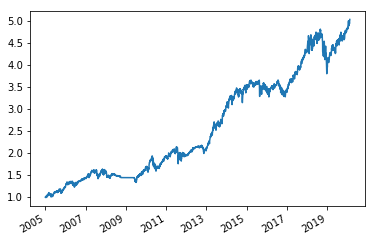

In [10]:
twr.plot()

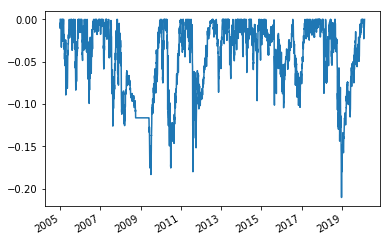

In [11]:
dd.plot()

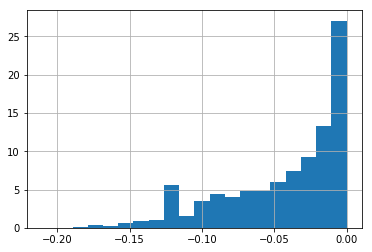

In [12]:
dd.hist(density=True,bins=20)